# Multipanel Plots using CMIP6 Precipatitation Variable

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import gcsfs
import datetime
import os

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [3]:
df_ssp585 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & " +\
    "variable_id == 'pr' & experiment_id == 'ssp585' & member_id == 'r1i1p1f1'")
print('Length of df_ssp585:', len(df_ssp585))
df_ssp585.head(3)

Length of df_ssp585: 34


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2471,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
18988,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
66580,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314


In [4]:
#df_ssp585.source_id.value_counts()

In [5]:
model = 'GFDL-CM4'

zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]

In [6]:
gcs = gcsfs.GCSFileSystem(token='anon')
mapper = gcs.get_mapper(zstore_ssp585)
ds_ssp585 = xr.open_zarr(mapper, consolidated = True)
#ds_ssp585

# Convert to DATETIME
time coordinate is in "object" format, which we need to convert to datetime to be able to easily analyze the timeseries.

In [7]:
print('ssp585 date range:', ds_ssp585.time[0].values, ' , ', ds_ssp585.time[-1].values) #first date end date

ssp585 date range: 2015-01-16 12:00:00  ,  2100-12-16 12:00:00


In [8]:
start_time = pd.to_datetime(datetime.date(2015,1,15)) #set start date
time_new_ssp585 = [start_time + pd.DateOffset(months = x) for x in range(len(ds_ssp585.time))] #convert to date time

In [9]:
ds_ssp585 = ds_ssp585.assign_coords(time = time_new_ssp585) #assign converted datetime to dataset

In [10]:
pr_avg_ssp585 = ds_ssp585.groupby('time.month').mean()
#pr_avg_ssp585

## convert to mm/day

In [11]:
pr_avg_ssp585 = pr_avg_ssp585 * 86400
#pr_avg_ssp585.attrs['units'] = ' Precipitation (mm/day)' 

## Quick Plot

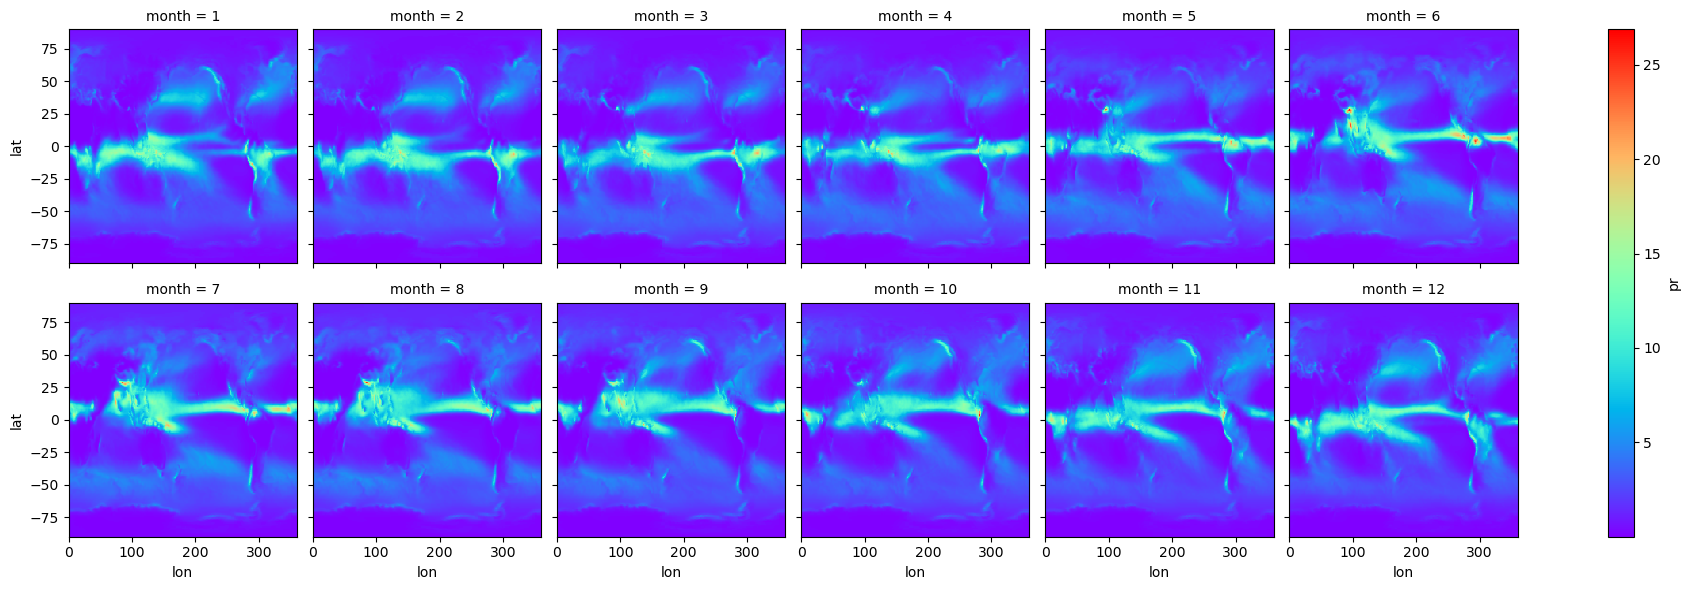

In [12]:
pr_avg_ssp585.pr.plot(col = 'month', col_wrap = 6, cmap = 'rainbow')

## Multipanel Plot - Monthly Precipitation

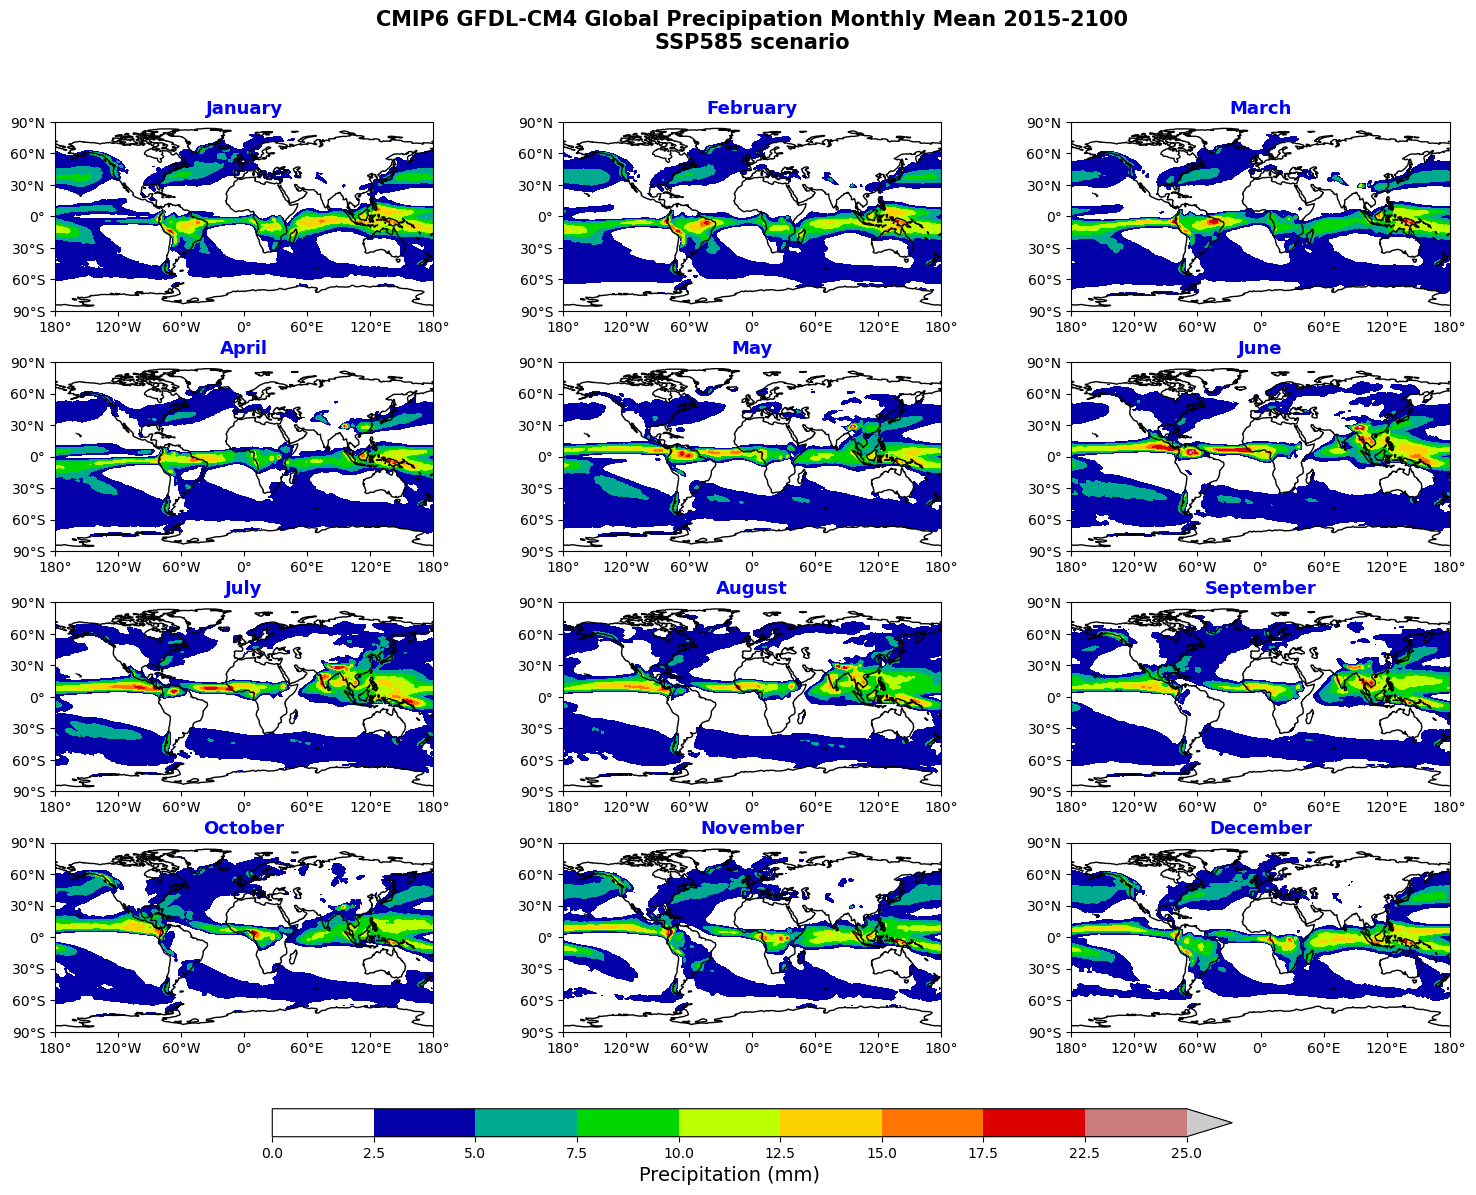

In [16]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import calendar # We'll use this library to easily add month name to subplot titles.

from matplotlib import colors

# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 14))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


# draw filled contours.daily global precip ~2mm/day
clevs = [0, 2.5 , 5, 7.5, 10, 12.5, 15, 17.5, 22.5, 25] #https://climatedataguide.ucar.edu/climate-data/precipitation-data-sets-overview-comparison-table#:~:text=Adler%20et%20al%20(2012)%20estimate,%C2%B1%207%25%20mm%2Fday.
# In future MetPy

# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = ds_ssp585.pr.sum(dim='time')>0


#Loop over all of the months and plot
for i,mnth in enumerate(pr_avg_ssp585['month']):
        #plt.subplot(nrows, ncols, i)
        # Select the season
        data=pr_avg_ssp585['pr'].sel(month=mnth)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=pr_avg_ssp585['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,pr_avg_ssp585['lat'],data, clevs, extend='max',
                          transform = ccrs.PlateCarree(),
                          cmap='nipy_spectral', norm=colors.LogNorm())

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the month
        axs[i].set_title(calendar.month_name[pr_avg_ssp585.pr[i, :, :].where(landmask).month.values], fontsize = 13, 
          fontweight = 'bold', color = 'b')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.27)


#plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')

#plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.175, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', extend='max')
cbar.set_label(label='Precipitation (mm)', color = 'k', size=14)

# Add a big title at the top
plt.suptitle('CMIP6 GFDL-CM4 Global Precipipation Monthly Mean 2015-2100\nSSP585 scenario', fontsize = 15, fontweight ='bold')


# Now we can save a high resolution (300dpi) version of the figure:
plt.savefig('Fig_prec_GFDL_585_pr_mon_2015_2100.png', format = 'png', dpi = 300)

## Extra: Plot with pcolormesh

In [14]:
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = ds_ssp585.pr.sum(dim='time')>0

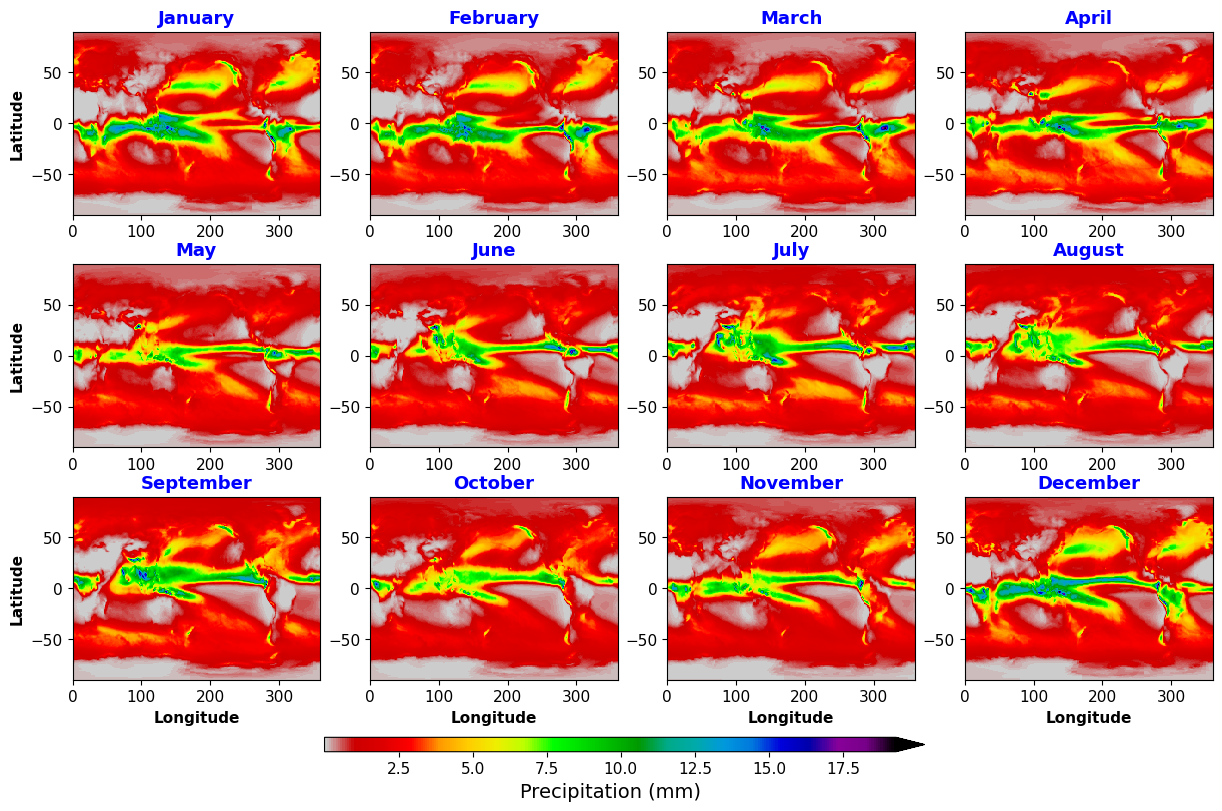

In [15]:
fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = pr_avg_ssp585.pr[i-1, :, :].where(landmask) # Remember that in Python, the data index starts at 0, but the subplot index start at 1.
    p = plt.pcolormesh(pr_avg_ssp585.lon, pr_avg_ssp585.lat, dataplot,
                   cmap = 'nipy_spectral_r',
                   ) 
    #plt.xlim([233,295])
    #plt.ylim([25,50])
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13, 
              fontweight = 'bold', color = 'b')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color = 'k', size=14)
